# Paper Replicating

## Setup

### Import Libraries from Going modular

In [1]:
import sys
sys.path.append('../')
from going_modular import data_setup, engine
from helper_function import download_data, set_seeds, plot_loss_curves

/home/bestlabmct/miniconda3/envs/py38belajarpt/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import Libraries

In [2]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torchinfo import summary

### Device Agnostic

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Tersedia GPU")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Tersedia MPS Apple Silicon")
else:
    device = torch.device("cpu")
    print("Tersedia CPU")

Tersedia GPU


## Get Data

Download Pizza Steak Sushi Dataset

In [4]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
train_dir = image_path / "train"
test_dir = image_path / "test"

print(f"Image path: {image_path}\nTrain path: {train_dir}\nTest path: {test_dir}\n")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
Image path: data/pizza_steak_sushi
Train path: data/pizza_steak_sushi/train
Test path: data/pizza_steak_sushi/test



### Create DataLoaders

#### Membuat Fungsi Transforms

In [5]:
IMG_SIZE = 224
BATCH_SIZE = 32

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

#### Memuat DataLoaders

In [6]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE,
)

In [7]:
print(f"Length of train_dataloader: {len(train_dataloader)}\nLength of test_dataloader: {len(test_dataloader)}\n")
print(f"Class names: {class_names}\n")

Length of train_dataloader: 8
Length of test_dataloader: 3

Class names: ['pizza', 'steak', 'sushi']



#### Mencoba DataLoader

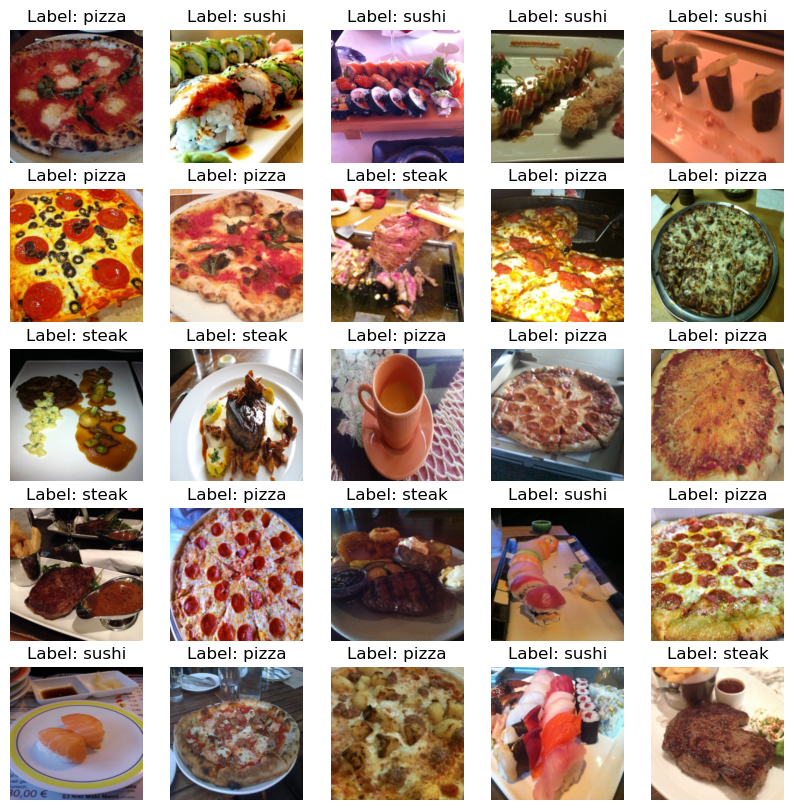

In [8]:
image_batch, label_batch = next(iter(train_dataloader))

def plot_images(images, labels, class_names):
    fig, ax = plt.subplots(figsize=(10, 10))
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title(f"Label: {class_names[labels[i]]}")
        plt.axis("off")

plot_images(images=image_batch, labels=label_batch, class_names=class_names)

## Membuat Model

### Block 1: Embedded Patches

In [9]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embbed_dim:int=768,
                 batch_size:int=32,
                 img_size:tuple=(224, 224)):
        super().__init__()
        
        # Create a convolutional layer to convert image to patches
        self.patch_conv = nn.Conv2d(in_channels=in_channels,
                                    out_channels=embbed_dim,
                                    kernel_size=patch_size,
                                    stride=patch_size,
                                    padding=0)
        # create a flatten layer to flatten the patches
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        # create the class token
        self.class_token = nn.Parameter(torch.randn(batch_size, 1, embbed_dim), requires_grad=True)
        # count the number of patches for the positional embedding
        self.num_patches = int(img_size[0] // patch_size) * (img_size[1] // patch_size)
        # create the positional embedding
        self.positional_embedding = nn.Parameter(torch.randn(1, self.num_patches + 1, embbed_dim, requires_grad=True))

    def forward(self, x):
        # get the image resolution
        img_res = x.shape[-1]
        # create assert if the image resolution is not divisible by patch size
        assert img_res % self.patch_conv.kernel_size[0] == 0, f"Image resolution {img_res} must be divisible by patch size {self.patch_conv.kernel_size[0]}"

        # forward the image to the patch convolutional layer
        x = self.patch_conv(x)
        # forward the patches to the flatten layer
        x = self.flatten(x)
        # permute the patches to the right shape
        x = x.permute(0, 2, 1)
        # forward to the class token
        x_class_token = torch.cat((self.class_token, x), dim=1)
        # forward to the positional embedding
        x_pos_embedding = x_class_token + self.positional_embedding

        return x_pos_embedding

#### Mencoba forward pass

In [10]:
single_img = image_batch[0]

# instantiate the patch embedding
patch_embedding = PatchEmbedding(in_channels=3, patch_size=16, embbed_dim=768, batch_size=1, img_size=(IMG_SIZE, IMG_SIZE))
# forward the image to the patch embedding
single_img_patch_emb = patch_embedding(single_img.unsqueeze(0))
print(f"Shape of single_img_patch_emb: {single_img_patch_emb.shape}\n")

Shape of single_img_patch_emb: torch.Size([1, 197, 768])



### Block 2: Multi-head Attention

In [11]:
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self,
                 embbed_dim:int=768,
                 num_heads:int=12,
                 attn_droput:float=0.0,
                 ):
        super().__init__()

        # Create norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embbed_dim)
        # Create multihead attention layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embbed_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_droput,
                                                    batch_first=True)
        
    def forward(self, x):
        # normalize the input
        x_norm = self.layer_norm(x)
        # forward to the multihead attention layer
        x_after_multihead, _ = self.multihead_attn(x_norm, x_norm, x_norm, need_weights=False)

        return x_after_multihead

#### Mencoba forward pass

In [12]:
# instantiate the multihead self attention block
multihead_self_attn = MultiheadSelfAttentionBlock(embbed_dim=768, num_heads=12, attn_droput=0.0)
# forward the image to the multihead self attention block
single_img_multihead_attn = multihead_self_attn(single_img_patch_emb)
print(f"Shape of single_img_multihead_attn: {single_img_multihead_attn.shape}\n")

Shape of single_img_multihead_attn: torch.Size([1, 197, 768])



### Block 3: MLP Block

In [13]:
class MLPBlock(nn.Module):
    def __init__(self,
                 embbed_dim:int=768,
                 mlp_size:int=3072,
                 dropout:float=0.1,):
        super().__init__()

        # Create norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embbed_dim)
        # Create mlp layer
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embbed_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embbed_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        # normalize the input
        x_norm = self.layer_norm(x)
        # forward to the mlp layer
        x_after_mlp = self.mlp(x_norm)

        return x_after_mlp

#### Mencoba forward pass

In [14]:
# create instance of the mlp block
mlp_block = MLPBlock(embbed_dim=768, mlp_size=3072, dropout=0.1)
# forward the image to the mlp block
single_img_mlp = mlp_block(single_img_multihead_attn)
print(f"Shape of single_img_mlp: {single_img_mlp.shape}\n")

Shape of single_img_mlp: torch.Size([1, 197, 768])



### Full Encoder Block

In [15]:
class EncoderBlock(nn.Module):
    def __init__(self,
                 embbed_dim:int=768,
                 num_heads:int=12,
                 attn_droput:float=0.0,
                 mlp_size:int=3072,
                 batch_size:int=32,
                 dropout:float=0.1):
        super().__init__()
        
        # Create multihead self attention layer
        self.multihead_self_attn = MultiheadSelfAttentionBlock(embbed_dim=embbed_dim,
                                                               num_heads=num_heads,
                                                               attn_droput=attn_droput)
        # Create mlp layer
        self.mlp = MLPBlock(embbed_dim=embbed_dim,
                            mlp_size=mlp_size,
                            dropout=dropout)
        
    def forward(self, x):
        # forward to the multihead self attention layer
        x_after_multihead_attn = self.multihead_self_attn(x)
        # add the input to the output of the multihead self attention layer
        x = x + x_after_multihead_attn
        # forward to the mlp layer
        x_after_mlp = self.mlp(x)
        # add the input to the output of the mlp layer
        x = x + x_after_mlp
        return x

#### Mencoba forward pass

In [17]:
# create instance of the encoder block
encoder_block = EncoderBlock(embbed_dim=768, num_heads=12, attn_droput=0.0, mlp_size=3072, batch_size=1, dropout=0.1)
# forward the image to the encoder block
single_img_encoder_block = encoder_block(single_img_patch_emb)
print(f"Shape of single_img_encoder_block: {single_img_encoder_block.shape}\n")

Shape of single_img_encoder_block: torch.Size([1, 197, 768])



In [23]:
summary(encoder_block, (1, 196, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape               Output Shape              Param #                   Trainable
EncoderBlock (EncoderBlock)                             [1, 196, 768]             [1, 196, 768]             --                        True
├─MultiheadSelfAttentionBlock (multihead_self_attn)     [1, 196, 768]             [1, 196, 768]             --                        True
│    └─LayerNorm (layer_norm)                           [1, 196, 768]             [1, 196, 768]             1,536                     True
│    └─MultiheadAttention (multihead_attn)              [1, 196, 768]             [1, 196, 768]             2,362,368                 True
├─MLPBlock (mlp)                                        [1, 196, 768]             [1, 196, 768]             --                        True
│    └─LayerNorm (layer_norm)                           [1, 196, 768]             [1, 196, 768]             1,536                     True
│    └─Sequential (mlp

### Membuat Encoder dengan ```nn.TransformerEncoder```

In [24]:
transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                       nhead=12,
                                                       dim_feedforward=3072,
                                                       dropout=0.1,
                                                       activation="gelu",
                                                       batch_first=True,
                                                       norm_first=True)

#### Mencoba forward pass

In [25]:
# forward pass
single_img_transformer_encoder_layer = transformer_encoder_layer(single_img_patch_emb)
print(f"Shape of single_img_transformer_encoder_layer: {single_img_transformer_encoder_layer.shape}\n")

Shape of single_img_transformer_encoder_layer: torch.Size([1, 197, 768])

